# Statoil / C-CORE Iceberg Recognition Challenge (Kaggle)

Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import json
import os
import keras

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, concatenate, Input, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


### Defining global variables

In [2]:
TRAIN_DATA_PATH = './Data/train.json'
TEST_DATA_PATH = './Data/test.json'
IMG_SIZE = 75
NUM_BAND = 3
GB_KERNEL = 3
GB_SIGMA = (3,3)
LP_KERNEL = 13
EPOCH = 500

### Reading data and preprocessing

In [3]:
def read_data(data_path):
    raw_data = pd.read_json(data_path)
    raw_data = raw_data.replace('na', np.nan)
    num_data = raw_data['id'].count()
    raw_data.index = raw_data['id']
    raw_data = raw_data.drop('id', axis=1)
    raw_data = raw_data.fillna(raw_data['inc_angle'].mean())
    
    return raw_data,num_data

We use the incidence angle, $\theta$ to construct a third channel, which weights the first two bands with $\cos^2 \theta$ and $\sin^2 \theta$ using the following: $b_3 = b_1\cos^2 \theta + b_2\sin^2 \theta$. By using the trigonometric functions, the third channel is basically an implementation of incidence angle normalization.For the incidence angles which are not available, we set it to 45 degrees, such that $b_3$ will be the average of $b_1$ and $b_2$.

In [4]:
raw_data, NUM_DATA=read_data(TRAIN_DATA_PATH)

In [5]:
band_1=raw_data['band_1'].values
band_2=raw_data['band_2'].values
inc_angle = raw_data['inc_angle'].values / 365 * 2 * np.pi
is_iceberg = raw_data['is_iceberg'].values
target = pd.Series(raw_data['is_iceberg'])
target_one_hot = pd.get_dummies(target, sparse=False)
one_hot_labels = np.asarray(target_one_hot)

In [6]:
def construct_band(band_1, band_2, inc_angle, num_data):
    sin_square = (np.sin(inc_angle))**2
    cos_square = (np.cos(inc_angle))**2
    tan_square = (np.tan(inc_angle))**2
    band = []
    for i in range(num_data):
        #band_3 = np.log10(np.array(band_1[i])**2*sin_square[i])/np.log10(np.array(band_2[i])**2*cos_square[i])
        band_3 = np.array(band_1[i])*np.array(band_2[i])*tan_square[i]+np.log10(np.array(band_1[i])**2*sin_square[i])/np.log10(np.array(band_2[i])**2*cos_square[i])
        band.append([band_1[i], band_2[i], band_3])
    band = np.array(band,dtype=np.float32)
    return band  

def normalize(band, num_band):     
    for i in range(num_band):   
        numerator=band[:,i,:]-np.reshape(np.min(band[:,i,:], axis=1),(-1,1))
        denominator = np.reshape(np.max(band[:,i,:], axis=1)-np.min(band[:,i,:], axis=1),(-1,1))
        band[:,i,:] = numerator/denominator
    return band

def preprocess(band_1, band_2, inc_angle, num_data, num_band, img_size):
    band = construct_band(band_1, band_2, inc_angle, num_data)
    band = normalize(band, num_band)*255
    image_data = np.reshape(band, (num_data, num_band, img_size, img_size))
    image_data = np.swapaxes(image_data, 1,3)
    return image_data 

def plot_rand(image_data, num_data, plot_type = 'default', kernel = 7, sigma = 10, laplacian_kernel = 7):
    np.random.seed(10)
    random_idx = np.random.choice(range(NUM_DATA), 12)
    plt.figure(figsize=(20,120))
    plt.subplot(36, 6, 6)    
    j = 1

    for i in range(12):        
        for k in range(3):
            plt.subplot(36, 6, j+k)
            if plot_type=='laplacian':
                plt.imshow(cv2.Laplacian(image_data[random_idx[i], :, :, k], cv2.CV_32F, ksize=kernel), cmap='viridis')
                #plt.imshow(cv2.Sobel(image_data[random_idx[i], :, :, k], cv2.CV_32F, 1,1,ksize=kernel), cmap='viridis')
                
            elif plot_type=='gaussian':
                plt.imshow(cv2.bilateralFilter(image_data[random_idx[i], :, :, 0], kernel, sigma, sigma), cmap='viridis')
            elif plot_type=='gaussian_laplacian':
                plt.imshow(cv2.bilateralFilter(cv2.Laplacian(image_data[random_idx[i], :, :, 0], cv2.CV_32F, ksize=laplacian_kernel), kernel, sigma, sigma), cmap='viridis')
            else:
                plt.imshow(image_data[random_idx[i], :, :, k], cmap='viridis')
            
            plt.axis('off')
            plt.title("Band " + str(k+1) + " " + str(random_idx[i]) + "/" + str(is_iceberg[random_idx[i]]))
        j+=3    
    plt.show() 
    
def prediction_model(file_path, X_test):
    model = keras.models.load_model(file_path)    
    y = model.predict(X_test)
    return y

In [7]:
image_data = preprocess(band_1, band_2, inc_angle, NUM_DATA, NUM_BAND, IMG_SIZE)

In [8]:
# plot_rand(image_data, NUM_DATA)   
# plot_rand(image_data, NUM_DATA, 'laplacian', LP_KERNEL)  
# plot_rand(image_data, NUM_DATA, 'gaussian', GB_KERNEL, GB_SIGMA[0])  
# plot_rand(image_data, NUM_DATA, 'gaussian_laplacian', GB_KERNEL, GB_SIGMA[0], LP_KERNEL) 

## Building Convolutional Neural Net

In [9]:
def model_1():
       
    #base_model= InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=(im_size, im_size, 3), pooling=None, classes=1000) 
    base_model= Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=(im_size, im_size, NUM_BAND), pooling=None, classes=1000) 
    x = base_model.output
    #x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(512, activation='elu')(x)
    x = Dropout(0.35)(x)
    x = Dense(128, activation='elu')(x)
    x = Dropout(0.35)(x)    
    pred = Dense(2, activation='softmax')(x)
    
    model = Model(inputs = base_model.input, outputs = pred)
    
    return model

In [10]:
def model_2():
       
    base_model= InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=(im_size, im_size, 3), pooling=None, classes=1000) 
    #base_model= Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=(im_size, im_size, NUM_BAND), pooling=None, classes=1000) 
    x = base_model.output
    #x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(512, activation='elu')(x)
    x = Dropout(0.35)(x)
    x = Dense(128, activation='elu')(x)
    x = Dropout(0.35)(x)    
    pred = Dense(2, activation='softmax')(x)
    
    model = Model(inputs = base_model.input, outputs = pred)
    
    return model

In [11]:
def model_3():
       
    #base_model= InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=(im_size, im_size, 3), pooling=None, classes=1000) 
    base_model= Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=(im_size, im_size, NUM_BAND), pooling=None, classes=1000) 
    x = base_model.output
    #x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    
    inc_input = Input(shape=(1,), name='inc_angle') 
    x_inc = BatchNormalization()(inc_input)
    
    x = concatenate([x, x_inc])
    
    x = Dense(512, activation='elu')(x)
    x = Dropout(0.55)(x)  
    pred = Dense(2, activation='softmax')(x)    
       
        
    model = Model(inputs = [base_model.input, inc_input], outputs = pred)
    
    return model

In [12]:
def train(model, X_train, Y_train, X_valid, Y_valid, epochs, callback, augment, filename):
    
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay= 5e-8)
    
#     for layer in model.layers[:45]:
#         layer.trainable = False
#     for layer in model.layers[45:]:
#         layer.trainable = True
        
    if callback:    
        callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=30, verbose=1),
                          keras.callbacks.ModelCheckpoint('./Callbacks/' + filename, 
                                                          monitor='val_acc', verbose=0, 
                                                          save_best_only=True, save_weights_only=False, 
                                                          mode='auto', period=1)]

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    if augment:
        datagen = ImageDataGenerator(horizontal_flip = True,
                             vertical_flip = True,
                             width_shift_range = 0.20,
                             height_shift_range = 0.20,
                             zoom_range = 0.20,
                             rotation_range = 40)
        history = model.fit_generator(datagen.flow(X_train,Y_train), len(X_train)/8, epochs=epochs, verbose=1, 
                                      callbacks=callbacks_list, validation_data=(X_valid, Y_valid), shuffle=True, 
                                      initial_epoch=0)
    else:
        history = model.fit(X_train, Y_train, 
                            epochs=epochs, validation_data=(X_valid, Y_valid), verbose=1, callbacks=callbacks_list)

    plt.figure(figsize=(20,10))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy', fontsize = 15)
    plt.ylabel('Accuracy', fontsize = 15)
    plt.xlabel('Epoch', fontsize = 15)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 15)
        
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss', fontsize = 15)
    plt.ylabel('Loss', fontsize = 15)
    plt.xlabel('Epoch', fontsize = 15)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 15)
    plt.show()

In [13]:
im_size = 200
X = {}
X['raw']=[]
X['filter']=[]
X['sharp']=[]

for i in tqdm(range(NUM_DATA)):
    X['filter'].append(cv2.resize(cv2.bilateralFilter(image_data[i], GB_KERNEL, GB_SIGMA[0], GB_SIGMA[1]), (im_size, im_size), interpolation = cv2.INTER_LINEAR))
    X['sharp'].append(cv2.resize(cv2.Sobel(image_data[i], cv2.CV_32F, 0, 1, LP_KERNEL), (im_size, im_size), interpolation = cv2.INTER_LINEAR))
    X['raw'].append(cv2.resize(image_data[i],(im_size, im_size), interpolation = cv2.INTER_LINEAR))

X['filter'] = np.array(X['filter'])
X['sharp'] = np.array(X['sharp'])
X['raw'] = np.array(X['raw'])



100%|██████████| 1604/1604 [00:01<00:00, 832.73it/s]


raw
Train on 1122 samples, validate on 482 samples
Epoch 1/500
1122/1122 [==============================] - 21s - loss: 1.4102 - acc: 0.7299 - val_loss: 1.2535 - val_acc: 0.6141
Epoch 2/500
1122/1122 [==============================] - 16s - loss: 0.2673 - acc: 0.8939 - val_loss: 1.3673 - val_acc: 0.6784
Epoch 3/500
1122/1122 [==============================] - 15s - loss: 0.1597 - acc: 0.9394 - val_loss: 1.0010 - val_acc: 0.6722
Epoch 4/500
1122/1122 [==============================] - 15s - loss: 0.0784 - acc: 0.9750 - val_loss: 1.6530 - val_acc: 0.6618
Epoch 5/500
1122/1122 [==============================] - 16s - loss: 0.0277 - acc: 0.9938 - val_loss: 0.9563 - val_acc: 0.7282
Epoch 6/500
1122/1122 [==============================] - 16s - loss: 0.0505 - acc: 0.9893 - val_loss: 1.0169 - val_acc: 0.7531
Epoch 7/500
1122/1122 [==============================] - 16s - loss: 0.0262 - acc: 0.9929 - val_loss: 0.7949 - val_acc: 0.8112
Epoch 8/500
1122/1122 [==============================] - 16s

1122/1122 [==============================] - 16s - loss: 0.0224 - acc: 0.9982 - val_loss: 0.3737 - val_acc: 0.9046
Epoch 65/500
1122/1122 [==============================] - 15s - loss: 0.0598 - acc: 0.9920 - val_loss: 0.5866 - val_acc: 0.8900
Epoch 66/500
1122/1122 [==============================] - 15s - loss: 0.0237 - acc: 0.9938 - val_loss: 0.4964 - val_acc: 0.8983
Epoch 67/500
1122/1122 [==============================] - 15s - loss: 0.0091 - acc: 0.9964 - val_loss: 0.4662 - val_acc: 0.9046
Epoch 68/500
1122/1122 [==============================] - 15s - loss: 0.0045 - acc: 0.9991 - val_loss: 0.4809 - val_acc: 0.8942
Epoch 69/500
1122/1122 [==============================] - 15s - loss: 0.0290 - acc: 0.9938 - val_loss: 0.4479 - val_acc: 0.8693
Epoch 70/500
1122/1122 [==============================] - 15s - loss: 0.0096 - acc: 0.9973 - val_loss: 0.4303 - val_acc: 0.8859
Epoch 71/500
1122/1122 [==============================] - 15s - loss: 0.0063 - acc: 0.9991 - val_loss: 0.4573 - val_a

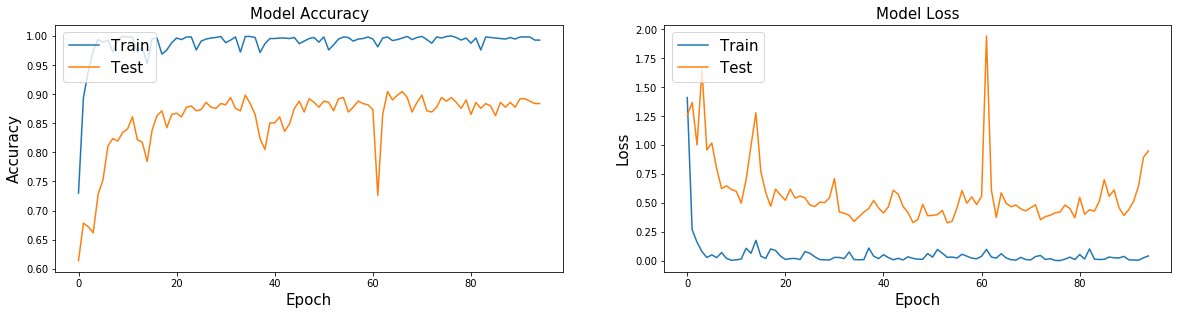

sharp
Train on 1122 samples, validate on 482 samples
Epoch 1/500
1122/1122 [==============================] - 21s - loss: 5.2453 - acc: 0.5936 - val_loss: 2.6599 - val_acc: 0.6639
Epoch 2/500
1122/1122 [==============================] - 16s - loss: 0.7092 - acc: 0.7308 - val_loss: 1.1234 - val_acc: 0.6867
Epoch 3/500
1122/1122 [==============================] - 16s - loss: 0.5101 - acc: 0.7451 - val_loss: 0.6782 - val_acc: 0.7199
Epoch 4/500
1122/1122 [==============================] - 15s - loss: 0.3208 - acc: 0.8627 - val_loss: 2.0592 - val_acc: 0.6888
Epoch 5/500
1122/1122 [==============================] - 15s - loss: 0.1699 - acc: 0.9447 - val_loss: 3.0110 - val_acc: 0.6826
Epoch 6/500
1122/1122 [==============================] - 16s - loss: 0.0559 - acc: 0.9786 - val_loss: 2.1097 - val_acc: 0.7241
Epoch 7/500
1122/1122 [==============================] - 15s - loss: 0.0586 - acc: 0.9866 - val_loss: 1.6475 - val_acc: 0.7241
Epoch 8/500
1122/1122 [==============================] - 1

1122/1122 [==============================] - 15s - loss: 0.0741 - acc: 0.9947 - val_loss: 1.1495 - val_acc: 0.8195
Epoch 65/500
1122/1122 [==============================] - 15s - loss: 0.0331 - acc: 0.9964 - val_loss: 1.8080 - val_acc: 0.8174
Epoch 66/500
1122/1122 [==============================] - 15s - loss: 0.1974 - acc: 0.9572 - val_loss: 0.9148 - val_acc: 0.8299
Epoch 67/500
1122/1122 [==============================] - 15s - loss: 0.0784 - acc: 0.9848 - val_loss: 0.4251 - val_acc: 0.8174
Epoch 68/500
1122/1122 [==============================] - 15s - loss: 0.0088 - acc: 0.9973 - val_loss: 0.4457 - val_acc: 0.8195
Epoch 69/500
1122/1122 [==============================] - 15s - loss: 0.0029 - acc: 0.9991 - val_loss: 0.5121 - val_acc: 0.8195
Epoch 70/500
1122/1122 [==============================] - 15s - loss: 0.0032 - acc: 0.9991 - val_loss: 0.6034 - val_acc: 0.7946
Epoch 71/500
1122/1122 [==============================] - 15s - loss: 0.1507 - acc: 0.9733 - val_loss: 1.4798 - val_a

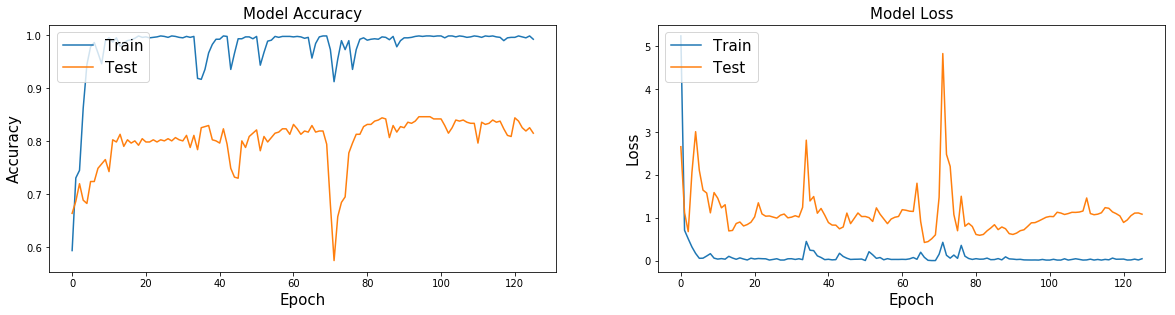

filter
Train on 1122 samples, validate on 482 samples
Epoch 1/500
1122/1122 [==============================] - 24s - loss: 2.2716 - acc: 0.6881 - val_loss: 1.1799 - val_acc: 0.5643
Epoch 2/500
1122/1122 [==============================] - 15s - loss: 0.3688 - acc: 0.8369 - val_loss: 3.5965 - val_acc: 0.5539
Epoch 3/500
1122/1122 [==============================] - 15s - loss: 0.2383 - acc: 0.9037 - val_loss: 2.2089 - val_acc: 0.5622
Epoch 4/500
1122/1122 [==============================] - 16s - loss: 0.1362 - acc: 0.9385 - val_loss: 1.2566 - val_acc: 0.6328
Epoch 5/500
1122/1122 [==============================] - 16s - loss: 0.0748 - acc: 0.9804 - val_loss: 0.6861 - val_acc: 0.7012
Epoch 6/500
1122/1122 [==============================] - 15s - loss: 0.0598 - acc: 0.9777 - val_loss: 1.7904 - val_acc: 0.6432
Epoch 7/500
1122/1122 [==============================] - 15s - loss: 0.0552 - acc: 0.9857 - val_loss: 1.5453 - val_acc: 0.6805
Epoch 8/500
1122/1122 [==============================] - 

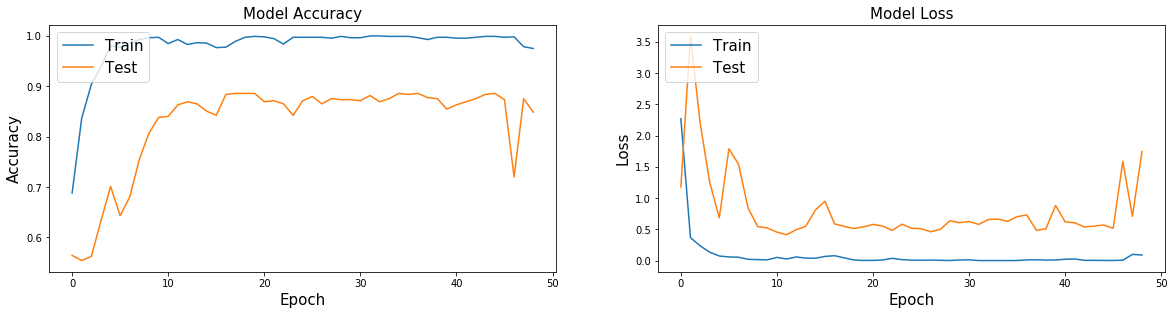

In [14]:
model ={}
X_train = {}
X_valid = {}
Y_train = {}
Y_valid = {}
inc_train = {}
inc_valid = {}

for key in X.keys():
    print(key)
    X_train[key], X_valid[key], inc_train[key], inc_valid[key], Y_train[key], Y_valid[key]= train_test_split(X[key], inc_angle, one_hot_labels, test_size = 0.30, shuffle = True)
    #X_train[key], X_valid[key], Y_train[key], Y_valid[key]= train_test_split(X[key], one_hot_labels, test_size = 0.30, shuffle = True)
    model[key] = model_3()    
    
    train(model[key], [X_train[key], inc_train[key]], Y_train[key], [X_valid[key], inc_valid[key]], Y_valid[key], EPOCH, True, False, 'params3_' + key +'.hd5f')

In [15]:
# model ={}
# X_train = {}
# X_valid = {}
# Y_train = {}
# Y_valid = {}

# for key in X.keys():
#     print(key)
#     X_train[key], X_valid[key], Y_train[key], Y_valid[key]= train_test_split(X[key], one_hot_labels, test_size = 0.30, shuffle = True)
#     model[key] = model_2()
    
#     train(model[key], X_train[key], Y_train[key], X_valid[key], Y_valid[key], EPOCH, True, True, 'params2_' + key +'.hd5f')

## Prediction

In [16]:
raw_data, NUM_TEST_DATA=read_data(TEST_DATA_PATH)

In [17]:
band_1=raw_data['band_1'].values
band_2=raw_data['band_2'].values
inc_angle = raw_data['inc_angle'].values / 365 * 2 * np.pi
image_data = preprocess(band_1, band_2, inc_angle, NUM_TEST_DATA, NUM_BAND, IMG_SIZE)

In [20]:
im_size=200
y_1 = {}
y_2 = {}
X_test = {} 

for key in X.keys():
    X_test[key] = []
    y_1[key] = []
    y_2[key] = []

for i in range(NUM_TEST_DATA):
    X_test['filter'].append(cv2.resize(cv2.bilateralFilter(image_data[i], GB_KERNEL, GB_SIGMA[0], GB_SIGMA[1]), (im_size, im_size), interpolation = cv2.INTER_LINEAR))
    X_test['sharp'].append(cv2.resize(cv2.Laplacian(image_data[i], LP_KERNEL), (im_size, im_size), interpolation = cv2.INTER_LINEAR))
    X_test['raw'].append(cv2.resize(image_data[i],(im_size, im_size), interpolation = cv2.INTER_LINEAR))      

In [21]:
for key in X.keys(): 
    X_test[key] = np.array(X_test[key])
    y_1[key].append(prediction_model('./Callbacks/params3_' + key +'.hd5f', [X_test[key], inc_angle]))
    #y_2[key].append(prediction_model('./Callbacks/params2_' + key +'.hd5f', X_test[key]))      
    y_1[key] = np.squeeze(np.array(y_1[key]))
    #y_2[key] = np.squeeze(np.array(y_2[key]))
    

MemoryError: 

In [ ]:
y_pred = np.zeros_like(y_1[key])
for key in X.keys(): 
    y_pred += y_1[key]# + y_2[key]


In [ ]:
y_pred /=3
submission = pd.DataFrame(y_pred[:,1], index=raw_data.index, columns = ['is_iceberg']) 
submission.to_csv('./Submission/submission.csv')
submission